# Aplication of machine learning algorithms

We will try to apply classical machine learning algorithm – KNN, observing and storing previous market tendencies in form of snapshots of `window_size` length, via which it would construct prediction with weighted sum

Main code is placed in `pipelines/knn_policy`

## Intuition
The K-Nearest Neighbors (KNN) baseline treats short segments of **log-returns** as patterns. If the most recent window of length $W$ resembles past windows followed by **up-moves**, we go long; if it resembles windows followed by **down-moves**, we go short. No parametric model is assumed; decisions are based on distances in the feature space and a weighted vote.


## Strategy components
Let $P_t$ denote the close on a uniform time grid (UTC), $p_t=\ln P_t$ and $r_t=p_t-p_{t-1}$.

**Features (right-aligned window):**
$$
x_t=[r_{t-W+1},\ldots,r_t]\in\mathbb{R}^W.
$$

**Target at horizon $H\ge 1$:**
$$
R^{(H)}_{t+1}=\sum_{j=1}^H r_{t+j},\qquad y_t=\mathrm{sign}\!\big(R^{(H)}_{t+1}\big)\in\{-1,+1\}.
$$

At each time $t$, the training set is strictly the **past**:
$$
\mathcal{D}_t=\{(\tilde x_s,y_s):\, W{-}1\le s\le t{-}H\},
$$
with standardization fitted **only on $\mathcal{D}_t$**: $\tilde x=(x-\mu_X)/\sigma_X$ (no look‑ahead).

**KNN decision with kernel and time-decay weights:**
$$
w_{t,s}\propto \exp\!\Big(-\frac{d(\tilde x_t,\tilde x_s)^2}{2h^2}\Big)\cdot \gamma^{\,t-s},\quad h>0,\ \gamma\in(0,1],
$$
where $d$ is Euclidean distance (cosine optional).

**Action specialization:** 
$$
\textrm{side}_t = \begin{cases}
+1, \,\, \sum_{s\in\mathcal N_K(t)} w_{t,s} y_s \leq -\theta, \\
-1, \,\, \sum_{s\in\mathcal N_K(t)} w_{t,s} y_s \geq \theta, \\
0, \,\,\, |\sum_{s\in\mathcal N_K(t)} w_{t,s} y_s| \in [-\theta, \theta]
\end{cases}
$$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import sys
from pathlib import Path

# setup path to project root
sys.path.append(str(Path.cwd().parent))

## PipeLine construction

load config and set seeds

In [2]:
from typing import Dict, Any, Optional
from pathlib import Path
import numpy as np
import random
import torch
import yaml

def load_config(path: Optional[Path] = None) -> Dict[str, Any]:
    if path is None:
        path = Path(__file__).with_name("config.yaml")
    with path.open("r", encoding="utf-8") as f:
        return yaml.safe_load(f)

def set_global_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    if torch is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

config_path = Path('../pipelines/knn_policy/config.yaml').resolve().absolute()
config = load_config(Path(config_path) if config_path else None)

seed = int(config.get("seed", 42))
set_global_seed(seed)

We do trade on close prices of previous day. So now we download historical data for configured currency

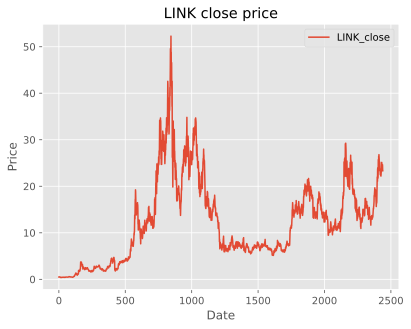

In [3]:
# tools for loading data
from pipelines.z_score_mean_reversion.data_loader import build_data_loader

data_loader = build_data_loader(config["data"])
price_frame = data_loader.load()

# visualize price
ax = price_frame[f"{config['data']['currency']}_close"].plot(x="date", y="close")
ax.set_title(f"{config['data']['currency']} close price")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True)
ax.legend()
ax.figure.show()

Next we create env over downloaded data (for any currecny we assume 8 digit precision)

In [4]:
import tensortrade.env.default as default
from tensortrade.env.default import actions as action_api, rewards as reward_api
from tensortrade.env.default.renderers import construct_renderers
from tensortrade.feed.core import DataFeed, NameSpace, Stream
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Portfolio, Wallet
from tensortrade.oms.instruments import Instrument, registry
import pandas as pd


def build_environment(
    data: pd.DataFrame,
    env_config: Dict[str, Any],
    currency: str,
    main_currency: str,
):
    exchange_name = "simulator"
    commission = env_config.get("fee_rate", 0.003)  # Default to 0.3% if not specified

    # prepare two instruments: USDT and currency
    if main_currency not in registry:
        Instrument(main_currency, 2, main_currency)
    base_instrument = registry[main_currency]

    if currency not in registry:
        registry[currency] = Instrument(currency, 8, currency)
    asset_instrument = registry[currency]

    # we do trade on close prices of previous day
    price_column = f"{currency}_close"
    price_stream = Stream.source(list(data[price_column]), dtype="float").rename(
        f"{main_currency}-{currency}"
    )

    # create exchange manager, simulating currency swapping between us and platform
    options = ExchangeOptions(commission=commission)
    exchange = Exchange(exchange_name, service=execute_order, options=options)(price_stream)

    # creation of wallets for cash and asset
    initial_cash = float(env_config.get("initial_cash", 0.0))
    initial_amount = float(env_config.get("initial_amount", 0.0))

    cash_wallet = Wallet(exchange, initial_cash * base_instrument)
    asset_wallet = Wallet(exchange, initial_amount * asset_instrument)
    portfolio = Portfolio(base_instrument, [cash_wallet, asset_wallet])

    # adding stream from price data frame
    with NameSpace(exchange_name):
        feature_streams = [
            Stream.source(list(data[price_column]), dtype="float").rename(price_column)
        ]

    renderer_streams = [
        Stream.source(data[f"{currency}_close"], dtype="float").rename("close"),
        Stream.source(data[f"{currency}_open"], dtype="float").rename("open"),
        Stream.source(data[f"{currency}_high"], dtype="float").rename("high"),
        Stream.source(data[f"{currency}_low"], dtype="float").rename("low"),
        Stream.source(data[f"{currency}_volume"], dtype="float").rename("volume"),
    ]
    if "date" in data.columns:
        renderer_streams.append(Stream.source(list(data["date"])).rename("date"))

    feed = DataFeed(feature_streams)
    feed.compile()

    renderer_feed = DataFeed(renderer_streams)
    renderer_feed.compile()

    renderer_cfg = env_config.get("renderers", "all")
    renderer_formats = env_config.get("renderer_formats", ["png", "html"])
    renderers = None
    if renderer_cfg:
        renderers = construct_renderers(renderer_cfg, display=True, save_formats=renderer_formats)


    action_scheme = action_api.get('bsh', cash=cash_wallet, asset=asset_wallet, proportion=0.1) # always trade 10% of source wallet
    reward_scheme = reward_api.get('simple')

    env_kwargs: Dict[str, Any] = {
        "portfolio": portfolio,
        "action_scheme": action_scheme,
        "reward_scheme": reward_scheme,
        "feed": feed,
        "renderer_feed": renderer_feed,
        "window_size": int(env_config.get("window_size", 30)),
        "max_episode_length": env_config.get("max_episode_length"),
        "enable_logger": False,
    }
    if renderers:
        env_kwargs["renderer"] = renderers

    env = default.create(**env_kwargs)
    return env


# Merge environment config with fee_rate from strategy section
env_config = config.get("environment", {}).copy()
env_config["fee_rate"] = config.get("strategy", {}).get("fee_rate", 0.003)

env = build_environment(
    price_frame,
    env_config,
    config["data"]["currency"],
    config["data"].get("main_currency", "USDT"),
)

Constructing renderers: type(identifier)=<class 'list'>


and now time to create strategy

In [5]:
from pipelines.knn_policy.strategy import (
    build_strategy,
)

strategy = build_strategy(config["strategy"], config.get("simulation", {}))

## Run of simulation

In [6]:
state, _ = env.reset(begin_from_start=True)
strategy.reset()

done = False
total_reward = 0.0
step_index = 0
warmup_steps = max(0, int(getattr(strategy.sim_config, "warmup_steps", 0)))

while not done:
    action = strategy.get_action(state)
    
    skip_decision = step_index < warmup_steps
    state, reward, terminated, truncated, _ = env.step(action, skip_decision=skip_decision)
    done = terminated or truncated
    total_reward += reward
    step_index += 1
    
print(f"Total reward: {total_reward}")

Total reward: 3.099615649854159


In [7]:
env.render()


# From KNN to an AI agent

KNN is a static, myopic learner. To evolve it into an **AI agent** in the same environment:
- **Direct policy learning (e.g., A2C/PPO):** learn $\pi_\theta(w_t\mid s_t)$ with $s_t=[\tilde x_t,\hat\sigma_t,$ trend/volume proxies$]$. Initialize or regularize toward KNN decisions (behavior cloning or KL penalty) to stabilize early training.
- **Meta-controller:** the agent chooses $(W,K,H,h,\gamma)$ online, while the inner decision remains KNN—preserving interpretability.
- **Hybrid/gated:** learn a regime gate or a short-horizon forecaster $\hat{\mathbb E}[r_{t+1}\mid s_t]$ to modulate KNN confidence and suppress counter‑trend entries.




# Design Q&A

**What data will be used as features?**  
Right‑aligned windows of **log‑returns** $x_t=[r_{t-W+1},\ldots,r_t]$. Optional augmentations: z‑score of log‑price, EWMA volatility $\hat\sigma_t$, and simple trend/volume proxies. Standardization is fit **only on the training slice** each step.

**What is the target variable?**  
$H$-step ahead return. Classification: $y_t=\mathrm{sign}\!\big(\sum_{j=1}^H r_{t+j}\big)\in\{-1,+1\}$. Regression: $R^{(H)}_{t+1}=\sum_{j=1}^H r_{t+j}\in\mathbb{R}$.

**How will the model be trained and tested?**  
**Rolling walk‑forward.** Train on $\{s\le t{-}H\}$, predict at $t$, execute at $t{+}1$. Hyperparameters $(W,K,H,h,\gamma)$ are tuned on train and **frozen** on OOS. All transforms are refit on train‑only slices.

**How frequently should the model be retrained?**  
KNN is lazy: at **every decision time** we rebuild the neighbor set and refit the scaler using only past data. Hyperparameter selection occurs only at **walk‑forward boundaries** (e.g., monthly/quarterly), not every bar.

**Which metrics will you use, and why?**  
**ROI** (level performance), **annualized Sharpe** (risk‑adjusted efficiency), **Max Drawdown** and **Calmar** (downside/tail risk), **Turnover** and **Fee share** (implementation realism). Together they cover level, efficiency, tail risk, and cost.
